In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
class RocketTransformation(object):
    """
    Класс, содержащий метод для создания набора сверточных слоев
    с ядрами свертки, имеющими  случайный размер, веса и параметры dilation 
    и padding, и метод для их применения к временным рядам с целью формирования
    новых признаков.

    Attributes
    ----------
    candidate_kernel_sizes : np.array 
        массив, содержащий возможные размеры ядер сверток
    in_channels : int
        количество входных каналов в сверточный слой
    out_channels : int
        количество исходящих каналов из сверточного слоя
    eps_std : float
        константа для добавления ее в знаменатель

    input_length : int
        длина временного ряда
    num_kernels : int
        количество ядер сверток (сверточных слоев)
    weight_sampling : str
        способ формирования случайных весов для ядер сверток
    kernel_sizes : np.array
        массив для хранения размеров (длины) ядер сверток
    dilations : np.array
        массив для хранения параметра dilation сверточных слоев
    paddings : np.array
        массив для хранения параметров padding сверточных слоев        
    conv1d_const_layers : list
        список для хранения созданных сверточных слоев
    
    Methods
    -------
    fit(X_in, num_kernels, weight_sampling=None)
        Метод для создания списка сверточных слоев nn.Conv1d
        со случайными параметрами
    transform(X_in)
        Метод для формирования новых признаков для временного ряда X_in
        путем применения к нему сверточных слоев и последующего вычисления 
        от результата свертки параметров ppv (proportion of positive values) 
        и max (максимальное значение / global max pooling) для каждого
        сверточного слоя
    __weights_overwrite(layer)
        Вспомогательный метод для создания случайных весов 
        у сверточного слоя layer в соответствии с распределением
        заданным параметром weight_sampling
    """
 
    #Возможные размеры ядер сверток
    candidate_kernel_sizes = np.array((7, 9, 11), dtype = np.int32)
    #Количество входных и исходящих каналов сверточных слоев
    in_channels = 1
    out_channels = 1

    #Константа добавляемая в знаменатель при нормализации величин,
    # чтобы избежать деления на 0 
    eps_std = 1e-8

    def _weights_overwrite(self, layer):
        """
        Метод для создания случайных весов ядра свертки
        у сверточного слоя layer в сответствии с аттрибутом
        self.weight_sampling:
        uniform - выборка весов из равномерного распределения U(-1, 1)
        binary - выборка весов из дискретного равномерного распределения [-1, 1]
        ternary - выборка весов из дискретного равномерного распределения [-1, 0, 1]
        normal (или значение отличное от предыдущих) - выборка весов из нормального распределения N(0, 1)
        """


        if self.weight_sampling == 'uniform':
            weight_init = nn.init.uniform_(layer.weight, a=-1, b=1).data #создание весов из заданного распределения
            weight_init_mean = weight_init.mean(dim=2) #вычисление среднего значения
            #присваивание слою весов из центрированной выборки
            layer.weight = nn.Parameter(weight_init - weight_init_mean, requires_grad=False) 

        elif self.weight_sampling == 'binary':
            weight_init = np.random.choice([-1, 1], layer.weight.shape)
            weight_init = torch.as_tensor(weight_init, dtype=torch.float32)
            layer.weight = nn.Parameter(weight_init, requires_grad=False)

        elif self.weight_sampling == 'ternary':
            weight_init = np.random.choice([-1, 0, 1], layer.weight.shape)
            weight_init = torch.as_tensor(weight_init, dtype=torch.float32)
            layer.weight = nn.Parameter(weight_init, requires_grad=False)

        else:
            weight_init = nn.init.normal_(layer.weight, mean=0, std=1).data
            weight_init_mean = weight_init.mean(dim=2)
            layer.weight = nn.Parameter(weight_init - weight_init_mean, requires_grad=False)

        #задаем величину bias случайным значением из равномерного распределения
        nn.init.uniform_(layer.bias, a=-1, b=1) 
        #nn.init.normal_(layer.bias, mean=0, std=1)
        bias_init = layer.bias
        layer.bias = nn.Parameter(bias_init, requires_grad=False)

    def __init__(self):
        self.input_length = None

        self.num_kernels = None
        self.weight_sampling = None
        self.kernel_sizes = None
        self.dilations = None
        self.paddings = None
        self.conv1d_const_layers = None

    def fit(self, X_in, num_kernels, weight_sampling=None):
        """
        Метод сначала создает массивы случайных значений параметров dilation, padding, 
        исходя из длины временных рядов из множества X_in. Затем данные параметры используются для создания 
        списка сверточных слоев nn.Conv1d с различными ядрами свертки, имеющими размер, 
        случайно выбранным из массива candidate_kernel_sizes, и весами, 
        случайно выбранными из распределения, определяемым параметром weight_sampling.

        Parameters
        ---------
        X_in : np.array
            Набор временных рядов
        num_kernels : int
            Количество ядер сверток (сверточных слоев)
        weight_sampling : str
            тип распределения, из которого будут браться веса для
            сверточных слоев
        """

        self.input_length = X_in.shape[1] #длина временного ряда
        self.num_kernels = num_kernels #количество ядер (сверточных слоев)
        self.weight_sampling = weight_sampling #тип распределения, из которого будут браться веса 

        #случайный выбор размеров ядер из заданного множества
        self.kernel_sizes = np.random.choice(self.candidate_kernel_sizes, self.num_kernels)

        #случайный выбор параметров dilations из заданного распределения
        dilations_A = np.log2((self.input_length * np.ones(self.num_kernels) - 1) / (self.kernel_sizes - 1))
        self.dilations = 2 ** np.random.uniform(0, dilations_A)
        self.dilations = np.int32(self.dilations)

        #определение параметров paddings, исходя из значений параметров dilations
        self.paddings = (self.kernel_sizes - 1) * self.dilations * np.random.randint(2, size=self.num_kernels) // 2

        self.conv1d_const_layers = [] #список сверточных слоев
        for i in range(self.num_kernels):

            #создание одномерного сверточного слоя
            conv1d_layer = nn.Conv1d(in_channels=self.in_channels, 
                                     out_channels=self.out_channels, 
                                     kernel_size=self.kernel_sizes[i],
                                     stride=1,
                                     padding=self.paddings[i],
                                     dilation=self.dilations[i], 
                                     bias=True)
            conv1d_layer.apply(self._weights_overwrite)
            self.conv1d_const_layers.append(conv1d_layer)

    def transform(self, X_in):
        """
        Метод, который применяет созданные сверточные слои nn.Conv1
        к временным рядам из множества X_in для создания новых признаков.
        Применение каждого сверточного слоя формирует два признака для временного ряда, 
        первый из которых равен оценке доли положительных значений (ppv) в полученной 
        после свертки последовательности, деленной на ее длину, 
        а второй - максимальному элементу полученной последовательности. 
        Метод возвращает тензор torch, строки, которого соответствуют временным рядам из 
        мн-ва X_in, а столбца новым созданным признакам.

        Parameters
        ----------
        X_in : np.array
            Набор временных рядов       
        """

        assert self.input_length == X_in.shape[1], 'Incorrect dimension of input data!'
        
        X_torch = torch.tensor(X_in, dtype=torch.float32)

        #Нормирование входных данных
        X_torch = (X_torch - X_torch.mean(dim=1, keepdim=True)) / (X_torch.std(dim=1, keepdim=True) + self.eps_std)
        
        X_torch = X_torch[: , None, :] #Добавление дополнительной размерности для входных каналов
        
        #Применение к временным рядам сверточных слоев, полученных в методе fit,
        #и создание новых признаков
        X_transformed = [] #массив для хранения новых признаков, полученных путем свертки
        with torch.no_grad():
            for conv1d_layer in self.conv1d_const_layers:
                output_tensor = conv1d_layer(X_torch) #расчет свертки для временного ряда
                
                #оценка доли положительных значений (ppv) в последовательности, 
                #полученной после свертки временного ряда, деленная на ее длину  
                ppv_normalized = (output_tensor > 0).sum(dim=2) / output_tensor.shape[-1]

                #поиск максимального значения в каждой последовательности
                max = output_tensor.max(dim=2).values

                #добавление новых признаков
                X_transformed.extend([ppv_normalized, max])
        X_transformed = torch.cat(X_transformed, dim=1)
        
        return X_transformed

In [3]:
class TimeSeriesDataset(Dataset):
    """
    Класс для формирования dataset, содержащего признаки временных рядов, 
    и в случае обучающего множества метки классов, 
    к которым они принадлежит

    Attributes
    ----------
    eps_std : float
        константа для добавления ее в знаменатель

    X_in : np.array / torch.tensor
        массив, содержащий признаки временных рядов
    y_in : np.array / torch.tensor
        массив, содержащий метки классов, к которым принадлежит
        временной ряд
    """

    eps_std = 1e-8

    def __init__(self, X_in, y_in = None, f_mean=None, f_std=None):        
        #поля для совокупности временных рядов и меток классов
        self.X = torch.as_tensor(X_in, dtype=torch.float32)
        self.y = y_in

        #Нормализация входных временных рядов
        self.f_mean = f_mean
        self.f_std = f_std
        self.X = (self.X - self.f_mean) / (self.f_std + self.eps_std)

        # One Hot Encoding для классов
        labels = np.int32(self.y - 1)
        labels_ohe = np.zeros((labels.size, labels.max() + 1))
        labels_ohe[np.arange(labels.size), labels] = 1
        self.y = labels_ohe

        #Количество временных рядов
        self.X_len = self.X.shape[0]

    def __getitem__(self, index):
        features = self.X[index]
        labels = None

        if self.y is not None:       
            labels = self.y[index]
            labels = torch.as_tensor(labels, dtype=torch.float32)
        
        return (features, labels)

    def __len__(self):
        return self.X_len

In [4]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader, num_epochs, device='cpu'):
    """
    Функция, возвращающая историю изменения целевой функции и 
    точности предсказания модели с увеличением эпох обучения модели

    Parameters
    ----------
    model : torch.nn.Sequential
        Модель, которая будет обучаться
    optimizer : torch.optim
        Алгоритм оптимизации
    criterion : Loss Function из модуля torch.nn
        Целевая функция
    train_dataloader : torch.utils.data.DataLoader
        Загрузчик батчей из обучающего множества
    val_dataloader : torch.utils.data.DataLoader
        Загрузчик батчей из валидационного множества
    num_epochs : int
        Количество эпох для обучения
    device : str
        Вычислительное устройство, используемое для расчетов

    Returns
    -------
    total_loss_train_list : list
        Список для хранения изменения значений функции ошибки на
        предсказаниях модели на обучающем множестве
    total_acc_train_list : list
        Список для хранения изменения значений точности (accuracy) 
        предсказания модели на обучающем множестве
    total_loss_val_list : list 
        Список для хранения изменения значений функции ошибки на
        предсказаниях модели на валидационном множестве
    total_acc_val_list : list
        Список для хранения изменения значений точности (accuracy)
        предсказания модели на валидационном множестве
    """

    model.to(device) #Переносим модель на вычислительное устройство
    
    #Списки для хранения истории изменения 
    total_loss_train_list = []
    total_acc_train_list = []

    total_loss_val_list = []
    total_acc_val_list = []
    
    #Цикл по эпохам для обучения модели и вычисления предсказания модели
    #на валидационном множестве данных
    for epoch_num in range(0, num_epochs):
        #переменные для хранения точности и значения целевой функции за одну эпоху
        total_acc_train, total_loss_train = 0.0, 0.0  
        
        #цикл для оптимизации весов модели
        model.train()
        for X_input, y_true in tqdm(train_dataloader):
            #переносим данные на выч-ое устройство
            X_input = X_input.to(device)
            y_true = y_true.to(device)
            
            #расчет предсказаний
            y_pred = model(X_input)
            
            #обнуления значений градиента
            optimizer.zero_grad()

            #вычисление функции ошибки и расчет обратного распространения ошибки
            batch_loss = criterion(y_pred, y_true)
            batch_loss.backward()
            total_loss_train += batch_loss.item()

            #обновление весов модели
            optimizer.step()
            
            #расчет точности предсказаний на batch
            y_pred_proba = torch.softmax(y_pred, dim=1)
            acc = (y_pred_proba.argmax(dim=1) == y_true.argmax(dim=1)).sum().item()
            total_acc_train += acc
            

        #расчет предсказания модели на валидационном множестве данных
        model.eval()
        total_loss_val, total_acc_val = 0.0, 0.0
        for X_input, y_true in val_dataloader:
            X_input = X_input.to(device)
            y_true = y_true.to(device)
            
            y_pred = model(X_input)
            
            batch_loss = criterion(y_pred, y_true)
            total_loss_val += batch_loss.item()

            y_pred_proba = torch.softmax(y_pred, dim=1)
            acc = (y_pred_proba.argmax(dim=1) == y_true.argmax(dim=1)).sum().item()
            total_acc_val += acc

        print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_dataloader.dataset): .5f}\
            | Train Accuracy: {total_acc_train / len(train_dataloader.dataset): .3f} \
            | Val Loss: {total_loss_val / len(val_dataloader.dataset): .5f} \
            | Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
        
        #сохранение значения целевой функции и точности предсказаний
        total_loss_train_list.append(total_loss_train/len(train_dataloader.dataset))
        total_acc_train_list.append(total_acc_train / len(train_dataloader.dataset))

        total_loss_val_list.append(total_loss_val / len(val_dataloader.dataset))
        total_acc_val_list.append(total_acc_val / len(val_dataloader.dataset))

    model.to('cpu')
    return total_loss_train_list, total_acc_train_list, total_loss_val_list, total_acc_val_list

In [5]:
def perform_experiment(X_train, X_test, y_train, y_test,
                       seeds_value, num_kernels=7500, weight_sampling='normal',
                       batch_size=10, learning_rate=3.2e-6, num_epochs=6, device='cuda'):
    """
    Функция, возвращающая точность (accuracy) предсказаний модели, 
    полученных на обучающем множестве и валидационном множестве,
    после обучения модели
    
    Parameters
    ----------
    X_train : np.array
        Набор временных рядов для обучения модели
    X_test : np.array
        Набор временных рядов для проверки предсказаний модели
    y_train : np.array
        Набор меток классов, к которым принадлежат временные ряды
        из обучающего множества
    y_test :  np.array
        Набор меток классов, к которым принадлежат временные ряды,
        используемые для проверки предсказаний модели    
    seeds_value : np.array
        Массив значений для фиксирования генераторов случайных значений.
        Размер массива соответсвует количеству экспериментов
    num_kernels : int
        Количество ядер сверток (сверточных слоев)
    weight_sampling : str
        Тип распределения, из которого будут браться веса для
        сверточных слоев
    batch_size : int
        Размер батча
    learning_rate : float
        Параметр скорости обучения модели
    num_epochs : int
        Количество эпох для обучения
    device : str
        Вычислительное устройство, используемое для расчетов

    Returns
    -------
    experiments_train_acc_list : list
        Список для хранения точности предсказаний модели на обучающем множестве
        после ее обучения
    experiments_val_acc_list : list
        Список для хранения точности предсказаний модели на тестовом(валидационном) 
        множестве после ее обучения
    """
    
    #Списки для хранения точности предсказаний модели в каждом эксперименте
    experiments_train_acc_list = []
    experiments_val_acc_list = []

    for idx_experiment, seed_value in enumerate(seeds_value):
        print(f'Experiment {idx_experiment}')
        
        #Фиксируем random seed
        torch.manual_seed(seed_value)
        np.random.seed(seed_value)

        #Создаем признаки для временных рядов путем применения сверточных слоев
        transformer = RocketTransformation()
        transformer.fit(X_train, num_kernels, weight_sampling)
        X_train_transformed = transformer.transform(X_train)
        X_test_transformed = transformer.transform(X_test)

        #Создаем загрузчики данных для формирования batchs
        f_mean_train = X_train_transformed.mean(dim=0, keepdim=True)
        f_std_train = X_train_transformed.std(dim=0, keepdim=True)

        train_dataset = TimeSeriesDataset(X_train_transformed, y_train, f_mean=f_mean_train, f_std=f_std_train)
        val_dataset = TimeSeriesDataset(X_test_transformed, y_test, f_mean=f_mean_train, f_std=f_std_train)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        #Определяем модель
        num_features = 2 * num_kernels
        num_classes = np.unique(y_train).size
        model = nn.Sequential(nn.Linear(num_features, num_classes, bias=True))

        #Инициализация весов для модели
        #weight_min = -np.sqrt(1 / num_features)
        #weight_max = np.sqrt(1 / num_features)
        #for layer in model._modules.values():
        #    torch.nn.init.uniform_(layer.weight, a=weight_min, b=weight_max)

        #Определяем методы оптимизации для поиска весов
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.98)

        #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        
        #Определяем целевую функцию
        criterion = nn.CrossEntropyLoss()

        #Выполняем обучение модели
        train_results = train(model, optimizer, criterion, train_dataloader, val_dataloader, 
                              num_epochs=num_epochs, device=device)

        #Запоминаем точность, полученную на train и validation datasets на заключительной эпохе
        experiments_train_acc_list.append(train_results[1][-1])
        experiments_val_acc_list.append(train_results[3][-1])
            
    return experiments_train_acc_list, experiments_val_acc_list

In [6]:
def get_half_of_conf_interval(x, confidence=0.95):
    #Функция для расчета полуширины доверительного интервала
    n = x.size
    s = np.std(x, ddof=1) #среднеквадратическое отклонение (несмещенная оценка)
    t = st.t.ppf((1 + confidence) / 2., n-1) #коэффициент Стьюдента
    hwidth = t * s / np.sqrt(n)
    return hwidth

## Загрузка данных

In [7]:
FOLDER_DATASET = './datasets/Ham/'

ar_train = np.genfromtxt(FOLDER_DATASET + 'Ham_TRAIN.txt')
ar_test = np.genfromtxt(FOLDER_DATASET + 'Ham_TEST.txt')

X_train = ar_train[..., 1:]
y_train = ar_train[..., 0]

X_test = ar_test[..., 1:]
y_test = ar_test[..., 0]

## Проведение вычислительных экспериментов

Проведем 5 вычислительных экспериментов для каждого типа ядер сверточных слоев.
Здесь <br>
normal - семплирование весов из нормального распределения $N(0, 1)$, с последующим центрированием <br>
uniform - семплирование весов из однородного распределения $U(0, 1)$, с последующим центрированием <br>
binary - семплирование весов из множества $[0, 1]$ <br>
ternary - семплирование весов из множества $[-1, 0, 1]$ <br>

Обучение модели будем выполнять на всем обучающем множестве <br>
Проверку значений будем выполнять на всем тестовом множестве <br>
Все эксперименты проводятся с одной скоростью обучения и для одинакового количества эпох обучения.

In [8]:
weight_sampling_list = ['normal', 'uniform', 'binary', 'ternary']
seeds_value = [31, 51, 62, 87, 91]
experiments_acc_train = {} #словарь для хранения оценок accuracy на train мн-ве
experiments_acc_val = {} #словарь для хранения оценок accuracy на val мн-ве
for weight_sampling in weight_sampling_list:
    print(weight_sampling)
    experiment_res = perform_experiment(X_train, X_test, y_train, y_test,
                                        seeds_value, weight_sampling=weight_sampling)
    experiments_acc_train[weight_sampling] = experiment_res[0]
    experiments_acc_val[weight_sampling] = experiment_res[1]

normal
Experiment 0


100%|██████████| 11/11 [00:00<00:00, 14.85it/s]


Epochs: 1 | Train Loss:  0.07270            | Train Accuracy:  0.505             | Val Loss:  123.43117             | Val Accuracy:  0.638


100%|██████████| 11/11 [00:00<00:00, 500.07it/s]


Epochs: 2 | Train Loss:  0.06836            | Train Accuracy:  0.569             | Val Loss:  123.42887             | Val Accuracy:  0.657


100%|██████████| 11/11 [00:00<00:00, 500.12it/s]


Epochs: 3 | Train Loss:  0.06234            | Train Accuracy:  0.670             | Val Loss:  123.42645             | Val Accuracy:  0.657


100%|██████████| 11/11 [00:00<00:00, 523.67it/s]


Epochs: 4 | Train Loss:  0.05551            | Train Accuracy:  0.771             | Val Loss:  123.42330             | Val Accuracy:  0.695


100%|██████████| 11/11 [00:00<00:00, 550.09it/s]


Epochs: 5 | Train Loss:  0.04900            | Train Accuracy:  0.844             | Val Loss:  123.42009             | Val Accuracy:  0.724


100%|██████████| 11/11 [00:00<00:00, 500.09it/s]


Epochs: 6 | Train Loss:  0.04317            | Train Accuracy:  0.881             | Val Loss:  123.41767             | Val Accuracy:  0.752
Experiment 1


100%|██████████| 11/11 [00:00<00:00, 268.29it/s]


Epochs: 1 | Train Loss:  0.07761            | Train Accuracy:  0.523             | Val Loss:  0.07855             | Val Accuracy:  0.571


100%|██████████| 11/11 [00:00<00:00, 239.13it/s]


Epochs: 2 | Train Loss:  0.07086            | Train Accuracy:  0.541             | Val Loss:  0.06933             | Val Accuracy:  0.648


100%|██████████| 11/11 [00:00<00:00, 289.48it/s]


Epochs: 3 | Train Loss:  0.06353            | Train Accuracy:  0.615             | Val Loss:  0.06257             | Val Accuracy:  0.705


100%|██████████| 11/11 [00:00<00:00, 647.06it/s]


Epochs: 4 | Train Loss:  0.05752            | Train Accuracy:  0.752             | Val Loss:  0.05716             | Val Accuracy:  0.752


100%|██████████| 11/11 [00:00<00:00, 500.04it/s]


Epochs: 5 | Train Loss:  0.05229            | Train Accuracy:  0.798             | Val Loss:  0.05322             | Val Accuracy:  0.781


100%|██████████| 11/11 [00:00<00:00, 500.16it/s]


Epochs: 6 | Train Loss:  0.04622            | Train Accuracy:  0.817             | Val Loss:  0.05067             | Val Accuracy:  0.790
Experiment 2


100%|██████████| 11/11 [00:00<00:00, 647.01it/s]


Epochs: 1 | Train Loss:  0.06758            | Train Accuracy:  0.578             | Val Loss:  0.06434             | Val Accuracy:  0.724


100%|██████████| 11/11 [00:00<00:00, 687.64it/s]


Epochs: 2 | Train Loss:  0.06310            | Train Accuracy:  0.670             | Val Loss:  0.06235             | Val Accuracy:  0.686


100%|██████████| 11/11 [00:00<00:00, 647.10it/s]


Epochs: 3 | Train Loss:  0.05891            | Train Accuracy:  0.725             | Val Loss:  0.06205             | Val Accuracy:  0.714


100%|██████████| 11/11 [00:00<00:00, 687.56it/s]


Epochs: 4 | Train Loss:  0.05374            | Train Accuracy:  0.761             | Val Loss:  0.05968             | Val Accuracy:  0.714


100%|██████████| 11/11 [00:00<00:00, 647.06it/s]


Epochs: 5 | Train Loss:  0.04817            | Train Accuracy:  0.862             | Val Loss:  0.05807             | Val Accuracy:  0.724


100%|██████████| 11/11 [00:00<00:00, 499.97it/s]


Epochs: 6 | Train Loss:  0.04397            | Train Accuracy:  0.853             | Val Loss:  0.05685             | Val Accuracy:  0.743
Experiment 3


100%|██████████| 11/11 [00:00<00:00, 647.04it/s]


Epochs: 1 | Train Loss:  0.06594            | Train Accuracy:  0.578             | Val Loss:  0.06591             | Val Accuracy:  0.638


100%|██████████| 11/11 [00:00<00:00, 611.13it/s]


Epochs: 2 | Train Loss:  0.06261            | Train Accuracy:  0.661             | Val Loss:  0.06268             | Val Accuracy:  0.686


100%|██████████| 11/11 [00:00<00:00, 647.15it/s]


Epochs: 3 | Train Loss:  0.05757            | Train Accuracy:  0.734             | Val Loss:  0.05888             | Val Accuracy:  0.695


100%|██████████| 11/11 [00:00<00:00, 647.08it/s]


Epochs: 4 | Train Loss:  0.05200            | Train Accuracy:  0.771             | Val Loss:  0.05585             | Val Accuracy:  0.724


100%|██████████| 11/11 [00:00<00:00, 550.02it/s]


Epochs: 5 | Train Loss:  0.04737            | Train Accuracy:  0.826             | Val Loss:  0.05378             | Val Accuracy:  0.762


100%|██████████| 11/11 [00:00<00:00, 611.12it/s]


Epochs: 6 | Train Loss:  0.04242            | Train Accuracy:  0.862             | Val Loss:  0.05218             | Val Accuracy:  0.771
Experiment 4


100%|██████████| 11/11 [00:00<00:00, 647.13it/s]


Epochs: 1 | Train Loss:  0.07004            | Train Accuracy:  0.532             | Val Loss:  383.03277             | Val Accuracy:  0.581


100%|██████████| 11/11 [00:00<00:00, 647.11it/s]


Epochs: 2 | Train Loss:  0.06476            | Train Accuracy:  0.615             | Val Loss:  383.02270             | Val Accuracy:  0.705


100%|██████████| 11/11 [00:00<00:00, 523.80it/s]


Epochs: 3 | Train Loss:  0.05825            | Train Accuracy:  0.706             | Val Loss:  383.01477             | Val Accuracy:  0.752


100%|██████████| 11/11 [00:00<00:00, 647.09it/s]


Epochs: 4 | Train Loss:  0.05231            | Train Accuracy:  0.780             | Val Loss:  383.00983             | Val Accuracy:  0.743


100%|██████████| 11/11 [00:00<00:00, 611.12it/s]


Epochs: 5 | Train Loss:  0.04704            | Train Accuracy:  0.826             | Val Loss:  383.00644             | Val Accuracy:  0.771


100%|██████████| 11/11 [00:00<00:00, 687.52it/s]


Epochs: 6 | Train Loss:  0.04175            | Train Accuracy:  0.862             | Val Loss:  383.00457             | Val Accuracy:  0.810
uniform
Experiment 0


100%|██████████| 11/11 [00:00<00:00, 239.15it/s]


Epochs: 1 | Train Loss:  0.07637            | Train Accuracy:  0.431             | Val Loss:  2.67315             | Val Accuracy:  0.581


100%|██████████| 11/11 [00:00<00:00, 255.82it/s]


Epochs: 2 | Train Loss:  0.07257            | Train Accuracy:  0.486             | Val Loss:  2.67110             | Val Accuracy:  0.629


100%|██████████| 11/11 [00:00<00:00, 255.81it/s]


Epochs: 3 | Train Loss:  0.06478            | Train Accuracy:  0.651             | Val Loss:  2.66403             | Val Accuracy:  0.667


100%|██████████| 11/11 [00:00<00:00, 647.03it/s]


Epochs: 4 | Train Loss:  0.05675            | Train Accuracy:  0.734             | Val Loss:  2.66115             | Val Accuracy:  0.676


100%|██████████| 11/11 [00:00<00:00, 550.07it/s]


Epochs: 5 | Train Loss:  0.04982            | Train Accuracy:  0.826             | Val Loss:  2.65925             | Val Accuracy:  0.695


100%|██████████| 11/11 [00:00<00:00, 500.01it/s]


Epochs: 6 | Train Loss:  0.04400            | Train Accuracy:  0.881             | Val Loss:  2.65908             | Val Accuracy:  0.724
Experiment 1


100%|██████████| 11/11 [00:00<00:00, 647.09it/s]


Epochs: 1 | Train Loss:  0.07290            | Train Accuracy:  0.495             | Val Loss:  0.07707             | Val Accuracy:  0.505


100%|██████████| 11/11 [00:00<00:00, 611.18it/s]


Epochs: 2 | Train Loss:  0.06578            | Train Accuracy:  0.596             | Val Loss:  0.07306             | Val Accuracy:  0.600


100%|██████████| 11/11 [00:00<00:00, 578.92it/s]


Epochs: 3 | Train Loss:  0.06051            | Train Accuracy:  0.688             | Val Loss:  0.07003             | Val Accuracy:  0.619


100%|██████████| 11/11 [00:00<00:00, 578.94it/s]


Epochs: 4 | Train Loss:  0.05471            | Train Accuracy:  0.725             | Val Loss:  0.06459             | Val Accuracy:  0.667


100%|██████████| 11/11 [00:00<00:00, 647.06it/s]


Epochs: 5 | Train Loss:  0.04793            | Train Accuracy:  0.798             | Val Loss:  0.06033             | Val Accuracy:  0.686


100%|██████████| 11/11 [00:00<00:00, 500.03it/s]


Epochs: 6 | Train Loss:  0.04362            | Train Accuracy:  0.853             | Val Loss:  0.06003             | Val Accuracy:  0.733
Experiment 2


100%|██████████| 11/11 [00:00<00:00, 647.07it/s]


Epochs: 1 | Train Loss:  0.06763            | Train Accuracy:  0.679             | Val Loss:  0.07086             | Val Accuracy:  0.629


100%|██████████| 11/11 [00:00<00:00, 647.06it/s]


Epochs: 2 | Train Loss:  0.06405            | Train Accuracy:  0.688             | Val Loss:  0.06547             | Val Accuracy:  0.667


100%|██████████| 11/11 [00:00<00:00, 611.13it/s]


Epochs: 3 | Train Loss:  0.05741            | Train Accuracy:  0.780             | Val Loss:  0.06050             | Val Accuracy:  0.724


100%|██████████| 11/11 [00:00<00:00, 687.50it/s]


Epochs: 4 | Train Loss:  0.05139            | Train Accuracy:  0.817             | Val Loss:  0.05663             | Val Accuracy:  0.771


100%|██████████| 11/11 [00:00<00:00, 647.12it/s]


Epochs: 5 | Train Loss:  0.04567            | Train Accuracy:  0.844             | Val Loss:  0.05459             | Val Accuracy:  0.800


100%|██████████| 11/11 [00:00<00:00, 500.01it/s]


Epochs: 6 | Train Loss:  0.04056            | Train Accuracy:  0.908             | Val Loss:  0.05330             | Val Accuracy:  0.790
Experiment 3


100%|██████████| 11/11 [00:00<00:00, 687.48it/s]


Epochs: 1 | Train Loss:  0.07460            | Train Accuracy:  0.486             | Val Loss:  0.07706             | Val Accuracy:  0.562


100%|██████████| 11/11 [00:00<00:00, 647.04it/s]


Epochs: 2 | Train Loss:  0.06455            | Train Accuracy:  0.651             | Val Loss:  0.06441             | Val Accuracy:  0.648


100%|██████████| 11/11 [00:00<00:00, 611.11it/s]


Epochs: 3 | Train Loss:  0.06096            | Train Accuracy:  0.697             | Val Loss:  0.06250             | Val Accuracy:  0.686


100%|██████████| 11/11 [00:00<00:00, 647.05it/s]


Epochs: 4 | Train Loss:  0.05701            | Train Accuracy:  0.725             | Val Loss:  0.05706             | Val Accuracy:  0.733


100%|██████████| 11/11 [00:00<00:00, 379.30it/s]


Epochs: 5 | Train Loss:  0.04956            | Train Accuracy:  0.761             | Val Loss:  0.05242             | Val Accuracy:  0.781


100%|██████████| 11/11 [00:00<00:00, 392.81it/s]


Epochs: 6 | Train Loss:  0.04240            | Train Accuracy:  0.862             | Val Loss:  0.05430             | Val Accuracy:  0.743
Experiment 4


100%|██████████| 11/11 [00:00<00:00, 234.04it/s]


Epochs: 1 | Train Loss:  0.07249            | Train Accuracy:  0.514             | Val Loss:  197.10447             | Val Accuracy:  0.552


100%|██████████| 11/11 [00:00<00:00, 97.35it/s]


Epochs: 2 | Train Loss:  0.06832            | Train Accuracy:  0.569             | Val Loss:  197.10032             | Val Accuracy:  0.600


100%|██████████| 11/11 [00:00<00:00, 410.97it/s]


Epochs: 3 | Train Loss:  0.06196            | Train Accuracy:  0.679             | Val Loss:  197.09617             | Val Accuracy:  0.657


100%|██████████| 11/11 [00:00<00:00, 550.01it/s]


Epochs: 4 | Train Loss:  0.05445            | Train Accuracy:  0.826             | Val Loss:  197.09051             | Val Accuracy:  0.667


100%|██████████| 11/11 [00:00<00:00, 578.97it/s]


Epochs: 5 | Train Loss:  0.04806            | Train Accuracy:  0.872             | Val Loss:  197.08610             | Val Accuracy:  0.657


100%|██████████| 11/11 [00:00<00:00, 611.07it/s]


Epochs: 6 | Train Loss:  0.04197            | Train Accuracy:  0.899             | Val Loss:  197.08238             | Val Accuracy:  0.705
binary
Experiment 0


100%|██████████| 11/11 [00:00<00:00, 578.93it/s]


Epochs: 1 | Train Loss:  0.06621            | Train Accuracy:  0.569             | Val Loss:  0.06623             | Val Accuracy:  0.648


100%|██████████| 11/11 [00:00<00:00, 611.13it/s]


Epochs: 2 | Train Loss:  0.05959            | Train Accuracy:  0.725             | Val Loss:  0.06265             | Val Accuracy:  0.657


100%|██████████| 11/11 [00:00<00:00, 611.21it/s]


Epochs: 3 | Train Loss:  0.05511            | Train Accuracy:  0.789             | Val Loss:  0.06213             | Val Accuracy:  0.705


100%|██████████| 11/11 [00:00<00:00, 499.96it/s]


Epochs: 4 | Train Loss:  0.05147            | Train Accuracy:  0.798             | Val Loss:  0.06076             | Val Accuracy:  0.724


100%|██████████| 11/11 [00:00<00:00, 611.08it/s]


Epochs: 5 | Train Loss:  0.04635            | Train Accuracy:  0.835             | Val Loss:  0.05767             | Val Accuracy:  0.733


100%|██████████| 11/11 [00:00<00:00, 523.73it/s]


Epochs: 6 | Train Loss:  0.04152            | Train Accuracy:  0.872             | Val Loss:  0.05405             | Val Accuracy:  0.743
Experiment 1


100%|██████████| 11/11 [00:00<00:00, 611.10it/s]


Epochs: 1 | Train Loss:  0.07366            | Train Accuracy:  0.550             | Val Loss:  0.06858             | Val Accuracy:  0.581


100%|██████████| 11/11 [00:00<00:00, 647.07it/s]


Epochs: 2 | Train Loss:  0.06916            | Train Accuracy:  0.624             | Val Loss:  0.06386             | Val Accuracy:  0.638


100%|██████████| 11/11 [00:00<00:00, 687.55it/s]


Epochs: 3 | Train Loss:  0.06281            | Train Accuracy:  0.697             | Val Loss:  0.05825             | Val Accuracy:  0.705


100%|██████████| 11/11 [00:00<00:00, 687.51it/s]


Epochs: 4 | Train Loss:  0.05534            | Train Accuracy:  0.771             | Val Loss:  0.05372             | Val Accuracy:  0.771


100%|██████████| 11/11 [00:00<00:00, 687.52it/s]


Epochs: 5 | Train Loss:  0.04878            | Train Accuracy:  0.798             | Val Loss:  0.05029             | Val Accuracy:  0.790


100%|██████████| 11/11 [00:00<00:00, 523.79it/s]


Epochs: 6 | Train Loss:  0.04423            | Train Accuracy:  0.853             | Val Loss:  0.04819             | Val Accuracy:  0.810
Experiment 2


100%|██████████| 11/11 [00:00<00:00, 578.95it/s]


Epochs: 1 | Train Loss:  0.07212            | Train Accuracy:  0.578             | Val Loss:  0.05919             | Val Accuracy:  0.714


100%|██████████| 11/11 [00:00<00:00, 578.90it/s]


Epochs: 2 | Train Loss:  0.06762            | Train Accuracy:  0.615             | Val Loss:  0.05733             | Val Accuracy:  0.705


100%|██████████| 11/11 [00:00<00:00, 611.12it/s]


Epochs: 3 | Train Loss:  0.05961            | Train Accuracy:  0.734             | Val Loss:  0.05458             | Val Accuracy:  0.743


100%|██████████| 11/11 [00:00<00:00, 578.93it/s]


Epochs: 4 | Train Loss:  0.05401            | Train Accuracy:  0.780             | Val Loss:  0.05158             | Val Accuracy:  0.771


100%|██████████| 11/11 [00:00<00:00, 423.10it/s]


Epochs: 5 | Train Loss:  0.04794            | Train Accuracy:  0.798             | Val Loss:  0.04927             | Val Accuracy:  0.752


100%|██████████| 11/11 [00:00<00:00, 578.92it/s]


Epochs: 6 | Train Loss:  0.04333            | Train Accuracy:  0.835             | Val Loss:  0.04699             | Val Accuracy:  0.781
Experiment 3


100%|██████████| 11/11 [00:00<00:00, 268.29it/s]


Epochs: 1 | Train Loss:  0.08058            | Train Accuracy:  0.440             | Val Loss:  0.07944             | Val Accuracy:  0.381


100%|██████████| 11/11 [00:00<00:00, 261.91it/s]


Epochs: 2 | Train Loss:  0.06714            | Train Accuracy:  0.606             | Val Loss:  0.06703             | Val Accuracy:  0.657


100%|██████████| 11/11 [00:00<00:00, 234.05it/s]


Epochs: 3 | Train Loss:  0.05954            | Train Accuracy:  0.661             | Val Loss:  0.06620             | Val Accuracy:  0.686


100%|██████████| 11/11 [00:00<00:00, 244.45it/s]


Epochs: 4 | Train Loss:  0.06062            | Train Accuracy:  0.752             | Val Loss:  0.06567             | Val Accuracy:  0.724


100%|██████████| 11/11 [00:00<00:00, 478.33it/s]


Epochs: 5 | Train Loss:  0.05471            | Train Accuracy:  0.752             | Val Loss:  0.05789             | Val Accuracy:  0.752


100%|██████████| 11/11 [00:00<00:00, 499.99it/s]


Epochs: 6 | Train Loss:  0.04593            | Train Accuracy:  0.817             | Val Loss:  0.05136             | Val Accuracy:  0.781
Experiment 4


100%|██████████| 11/11 [00:00<00:00, 647.06it/s]


Epochs: 1 | Train Loss:  0.09226            | Train Accuracy:  0.358             | Val Loss:  6.00521             | Val Accuracy:  0.457


100%|██████████| 11/11 [00:00<00:00, 647.08it/s]


Epochs: 2 | Train Loss:  0.07883            | Train Accuracy:  0.495             | Val Loss:  5.98721             | Val Accuracy:  0.619


100%|██████████| 11/11 [00:00<00:00, 647.07it/s]


Epochs: 3 | Train Loss:  0.06935            | Train Accuracy:  0.624             | Val Loss:  5.98779             | Val Accuracy:  0.705


100%|██████████| 11/11 [00:00<00:00, 687.54it/s]


Epochs: 4 | Train Loss:  0.06750            | Train Accuracy:  0.651             | Val Loss:  5.98551             | Val Accuracy:  0.695


100%|██████████| 11/11 [00:00<00:00, 523.83it/s]


Epochs: 5 | Train Loss:  0.05920            | Train Accuracy:  0.725             | Val Loss:  5.97709             | Val Accuracy:  0.752


100%|██████████| 11/11 [00:00<00:00, 611.06it/s]


Epochs: 6 | Train Loss:  0.04873            | Train Accuracy:  0.789             | Val Loss:  5.97118             | Val Accuracy:  0.743
ternary
Experiment 0


100%|██████████| 11/11 [00:00<00:00, 647.03it/s]


Epochs: 1 | Train Loss:  0.08481            | Train Accuracy:  0.394             | Val Loss:  52.69756             | Val Accuracy:  0.448


100%|██████████| 11/11 [00:00<00:00, 687.51it/s]


Epochs: 2 | Train Loss:  0.07219            | Train Accuracy:  0.541             | Val Loss:  52.68525             | Val Accuracy:  0.648


100%|██████████| 11/11 [00:00<00:00, 647.03it/s]


Epochs: 3 | Train Loss:  0.06610            | Train Accuracy:  0.688             | Val Loss:  52.68160             | Val Accuracy:  0.676


100%|██████████| 11/11 [00:00<00:00, 549.93it/s]


Epochs: 4 | Train Loss:  0.06191            | Train Accuracy:  0.697             | Val Loss:  52.67624             | Val Accuracy:  0.714


100%|██████████| 11/11 [00:00<00:00, 687.51it/s]


Epochs: 5 | Train Loss:  0.05256            | Train Accuracy:  0.734             | Val Loss:  52.66833             | Val Accuracy:  0.762


100%|██████████| 11/11 [00:00<00:00, 687.52it/s]


Epochs: 6 | Train Loss:  0.04501            | Train Accuracy:  0.835             | Val Loss:  52.66547             | Val Accuracy:  0.752
Experiment 1


100%|██████████| 11/11 [00:00<00:00, 578.95it/s]


Epochs: 1 | Train Loss:  0.07152            | Train Accuracy:  0.550             | Val Loss:  0.08312             | Val Accuracy:  0.457


100%|██████████| 11/11 [00:00<00:00, 578.97it/s]


Epochs: 2 | Train Loss:  0.06585            | Train Accuracy:  0.624             | Val Loss:  0.07611             | Val Accuracy:  0.533


100%|██████████| 11/11 [00:00<00:00, 647.10it/s]


Epochs: 3 | Train Loss:  0.05973            | Train Accuracy:  0.670             | Val Loss:  0.07040             | Val Accuracy:  0.638


100%|██████████| 11/11 [00:00<00:00, 550.03it/s]


Epochs: 4 | Train Loss:  0.05404            | Train Accuracy:  0.743             | Val Loss:  0.06714             | Val Accuracy:  0.648


100%|██████████| 11/11 [00:00<00:00, 500.03it/s]


Epochs: 5 | Train Loss:  0.04962            | Train Accuracy:  0.771             | Val Loss:  0.06431             | Val Accuracy:  0.676


100%|██████████| 11/11 [00:00<00:00, 647.05it/s]


Epochs: 6 | Train Loss:  0.04531            | Train Accuracy:  0.817             | Val Loss:  0.06192             | Val Accuracy:  0.676
Experiment 2


100%|██████████| 11/11 [00:00<00:00, 261.91it/s]


Epochs: 1 | Train Loss:  0.07859            | Train Accuracy:  0.486             | Val Loss:  0.07715             | Val Accuracy:  0.505


100%|██████████| 11/11 [00:00<00:00, 244.44it/s]


Epochs: 2 | Train Loss:  0.07292            | Train Accuracy:  0.486             | Val Loss:  0.07154             | Val Accuracy:  0.571


100%|██████████| 11/11 [00:00<00:00, 234.04it/s]


Epochs: 3 | Train Loss:  0.06572            | Train Accuracy:  0.624             | Val Loss:  0.06604             | Val Accuracy:  0.619


100%|██████████| 11/11 [00:00<00:00, 610.99it/s]


Epochs: 4 | Train Loss:  0.05906            | Train Accuracy:  0.688             | Val Loss:  0.06080             | Val Accuracy:  0.695


100%|██████████| 11/11 [00:00<00:00, 574.06it/s]


Epochs: 5 | Train Loss:  0.05112            | Train Accuracy:  0.807             | Val Loss:  0.05750             | Val Accuracy:  0.752


100%|██████████| 11/11 [00:00<00:00, 478.41it/s]


Epochs: 6 | Train Loss:  0.04562            | Train Accuracy:  0.844             | Val Loss:  0.05554             | Val Accuracy:  0.752
Experiment 3


100%|██████████| 11/11 [00:00<00:00, 647.03it/s]


Epochs: 1 | Train Loss:  0.08096            | Train Accuracy:  0.431             | Val Loss:  0.07934             | Val Accuracy:  0.562


100%|██████████| 11/11 [00:00<00:00, 687.54it/s]


Epochs: 2 | Train Loss:  0.07338            | Train Accuracy:  0.505             | Val Loss:  0.07199             | Val Accuracy:  0.667


100%|██████████| 11/11 [00:00<00:00, 611.11it/s]


Epochs: 3 | Train Loss:  0.06774            | Train Accuracy:  0.651             | Val Loss:  0.06857             | Val Accuracy:  0.686


100%|██████████| 11/11 [00:00<00:00, 647.06it/s]


Epochs: 4 | Train Loss:  0.06466            | Train Accuracy:  0.716             | Val Loss:  0.06540             | Val Accuracy:  0.686


100%|██████████| 11/11 [00:00<00:00, 523.81it/s]


Epochs: 5 | Train Loss:  0.05814            | Train Accuracy:  0.743             | Val Loss:  0.05867             | Val Accuracy:  0.743


100%|██████████| 11/11 [00:00<00:00, 611.20it/s]


Epochs: 6 | Train Loss:  0.05049            | Train Accuracy:  0.761             | Val Loss:  0.05629             | Val Accuracy:  0.781
Experiment 4


100%|██████████| 11/11 [00:00<00:00, 647.05it/s]


Epochs: 1 | Train Loss:  0.09439            | Train Accuracy:  0.459             | Val Loss:  0.08137             | Val Accuracy:  0.533


100%|██████████| 11/11 [00:00<00:00, 647.06it/s]


Epochs: 2 | Train Loss:  0.07552            | Train Accuracy:  0.523             | Val Loss:  0.06575             | Val Accuracy:  0.638


100%|██████████| 11/11 [00:00<00:00, 647.14it/s]


Epochs: 3 | Train Loss:  0.06986            | Train Accuracy:  0.624             | Val Loss:  0.07446             | Val Accuracy:  0.629


100%|██████████| 11/11 [00:00<00:00, 550.07it/s]


Epochs: 4 | Train Loss:  0.07222            | Train Accuracy:  0.642             | Val Loss:  0.07421             | Val Accuracy:  0.657


100%|██████████| 11/11 [00:00<00:00, 687.56it/s]


Epochs: 5 | Train Loss:  0.06271            | Train Accuracy:  0.688             | Val Loss:  0.06320             | Val Accuracy:  0.714


100%|██████████| 11/11 [00:00<00:00, 687.56it/s]


Epochs: 6 | Train Loss:  0.04911            | Train Accuracy:  0.807             | Val Loss:  0.05811             | Val Accuracy:  0.705


## Анализ результатов

In [9]:
#DataFrames на основе полученных значений accuracy
df_acc_train = pd.DataFrame.from_dict(experiments_acc_train, orient='index')
df_acc_val = pd.DataFrame.from_dict(experiments_acc_val, orient='index')

In [10]:
#расчет среднего значения accuracy и полуширины доверительного интервала
num_experiments = len(seeds_value)
df_acc_train['mean'] = \
    df_acc_train.iloc[:, 0:num_experiments].apply(lambda row: np.mean(row), 
                                                  axis=1)

df_acc_train['half_of_confidence_interval'] = \
    df_acc_train.iloc[:, 0:num_experiments].apply(lambda row: get_half_of_conf_interval(row), 
                                                  axis=1)

df_acc_val['mean'] = \
    df_acc_val.iloc[:, 0:num_experiments].apply(lambda row: np.mean(row), 
                                                  axis=1)

df_acc_val['half_of_confidence_interval'] = \
    df_acc_val.iloc[:, 0:num_experiments].apply(lambda row: get_half_of_conf_interval(row), 
                                                  axis=1)

In [11]:
df_acc_train

,0,1,2,3,4,mean,half_of_confidence_interval
normal,0.880734,0.816514,0.853211,0.862385,0.862385,0.855046,0.029486
uniform,0.880734,0.853211,0.908257,0.862385,0.899083,0.880734,0.029043
binary,0.871560,0.853211,0.834862,0.816514,0.788991,0.833028,0.039788
ternary,0.834862,0.816514,0.844037,0.761468,0.807339,0.812844,0.039951


In [12]:
df_acc_val

,0,1,2,3,4,mean,half_of_confidence_interval
normal,0.752381,0.790476,0.742857,0.771429,0.809524,0.773333,0.033863
uniform,0.723810,0.733333,0.790476,0.742857,0.704762,0.739048,0.039752
binary,0.742857,0.809524,0.780952,0.780952,0.742857,0.771429,0.035476
ternary,0.752381,0.676190,0.752381,0.780952,0.704762,0.733333,0.052219


Построим rрафик, отображающий среднюю оценку accuracy по всем экспериментам на train и val множествах
в зависимости от вида распределения, на основе которого были получены веса ядер
сверточных слоев, с доверительными интервалами, рассчитанными при доверительной вероятности 95%. <br>

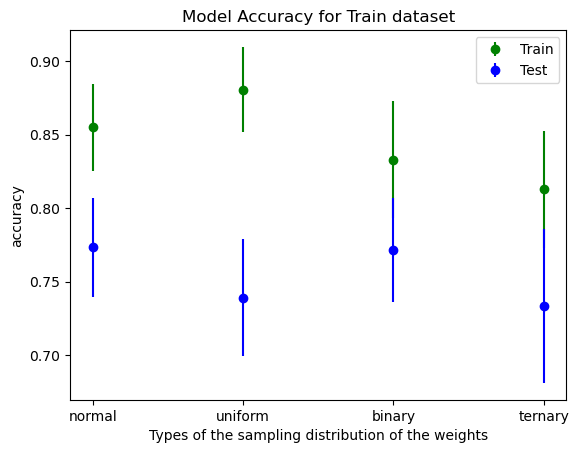

In [13]:
x_axis = df_acc_train.index
y_axis = df_acc_train['mean']
err_val = df_acc_train['half_of_confidence_interval'].values
 

plt.errorbar(x_axis, y_axis, yerr=err_val, fmt='og')

x_axis = df_acc_val.index
y_axis = df_acc_val['mean']
err_val = df_acc_val['half_of_confidence_interval'].values
plt.errorbar(x_axis, y_axis, yerr=err_val, fmt='ob')

plt.title('Model Accuracy for Train dataset')
plt.xlabel('Types of the sampling distribution of the weights')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

Из построенных графиков можно заключить, что точность предсказаний модели на обучающем и тестовом множестве
зависит от типа распределения, из которого была осуществлена выборка весов ядер сверток. На обучающем множестве 
максимальная точность достигается при выборе весов из равномерного распределения $U(-1, 1)$, а наименьшая -
при выборе весов из тернарных значений $[-1, 0, 1]$. При этом ширина доверительного интервала, построенного по 
5 вычислительным экспериментам, в случае выбора весов из бинарного множества $[-1, 1]$ и тернарного множества $[-1, 0, 1]$
больше, чем их выборе из равномерного $U(-1, 1)$ и нормального $N(0, 1)$ распределений. На тестовом множестве
максимальная точность модели достигается в случае выбора весов ядер сверток из нормального распределения $N(0, 1)$ и из множества 
бинарных значений $[-1, 1]$. При выборе весов из равномерного распределения $U(-1, 1)$ и из множества тернарных значений $[-1, 0, 1]$
происходит падение точности предсказаний и увеличение ширины доверительного интервала. <br>
Наибольшее расхождение между оценками точности предсказаний на обучающем и тестовом множествах наблюдается для случае выбора
весов ядер из равномерного распределения $U(-1, 1)$, а наименьшее - для случая выбора весов из множества 
бинарных значений $[-1, 1]$. Откуда можно предположить, что при прочих равных условиях выбор весов ядер сверток из бинарного распределения позволяет достичь более высокой точности в отсутствии значительного переобучения модели, чем при выборе весов другими способами.


С учетом ширины доверительных интервалов можно заключить, что полученные в данной работе точности предсказания модели на Ham dataset согласуются с точностью в 0.7257, полученной в работе "ROCKET: Exceptionally fast and accurate time series classification using random convolutional kernels."